In [65]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf

from tensorflow.keras import layers, models

In [66]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part2.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part2.npy")

# test data
X_TEST = np.load("Xtest_Classification_Part2.npy")

# X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], 50,50,1) / 255

X_TEST = X_TEST.reshape(X_TEST.shape[0], 50,50,1) / 255

print(f"xtrain: {X_TRAIN.shape},\nytrain: {Y_TRAIN.shape},\nx_test: {X_TEST.shape}")

xtrain: (7366, 2500),
ytrain: (7366,),
x_test: (1290, 50, 50, 1)


Function to display 30 images with labels in a grid of 5x6

In [67]:
def showImages(images, labels, offset = 0):
    class_names = ['Caucasian', 'African', 'Asian', 'Indian']

    plt.figure(figsize=(10,10))
    for i in range(30):
        plt.subplot(5,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i+offset], cmap="gray")

        plt.xlabel(class_names[ int( np.argmax(labels[i+offset]) ) ])
    plt.show()

In [68]:
train_img,test_img,train_labels,test_labels = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2, random_state=69, shuffle=True)

OVERSAMPLE para ficar os dados mais equilibrados

In [69]:
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(train_img, train_labels)

#CAREFULLLL
train_img = X_resampled

train_labels = y_resampled

In [70]:
#dont forget to reshape the images
train_img = train_img.reshape(train_img.shape[0], 50,50,1) / 255
test_img = test_img.reshape(test_img.shape[0], 50,50,1) / 255

In [71]:
# showImages(train_img, train_labels, offset=756)

In [72]:
print(f"train data has:\t {(train_labels == 0).sum()} caucasians")
print(f"\t\t {(train_labels == 1).sum()} africans")
print(f"\t\t {(train_labels == 2).sum()} asians")
print(f"\t\t {(train_labels == 3).sum()} indians")

print(f"test data has:\t {(test_labels == 0).sum()} caucasians")
print(f"\t\t {(test_labels == 1).sum()} africans")
print(f"\t\t {(test_labels == 2).sum()} asians")
print(f"\t\t {(test_labels == 3).sum()} indians")

train data has:	 3592 caucasians
		 3592 africans
		 1058 asians
		 964 indians
test data has:	 886 caucasians
		 63 africans
		 280 asians
		 245 indians


In [73]:
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels),y= train_labels)
print(weights)
weights_dict = {
    0:weights[0],
    1:weights[1],
    2:weights[2],
    3:weights[3]
}
print(weights_dict)

[0.6407294  0.6407294  2.17533081 2.38744813]
{0: 0.6407293986636972, 1: 0.6407293986636972, 2: 2.175330812854442, 3: 2.387448132780083}


In [74]:
model = models.Sequential(name="Manel")

# model.add( layers.RandomFlip(mode="vertical") )
model.add( layers.RandomFlip(mode="horizontal") ) #NAO faz data augmentation, apenas roda as imagens a toa

model.add(layers.Conv2D(32, (3, 3), activation='linear', input_shape=(50, 50, 1)))
model.add( layers.LeakyReLU() )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(64, (3, 3), activation='linear'))
model.add( layers.LeakyReLU() )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# model.add(layers.Conv2D(128, (3, 3), activation='linear'))
# model.add( layers.LeakyReLU() )
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))

# model.summary()

CONFIRMAR A SHAPE DOS DADOS TODOS

In [75]:
print(train_img.shape)
print(train_labels.shape)

print(test_img.shape)
print(test_labels.shape)

(9206, 50, 50, 1)
(9206,)
(1474, 50, 50, 1)
(1474,)


In [76]:
model.compile(optimizer='adam',
                #estamos a usar sparse categorical em vez de categorical cross entropy pq estamos a dar as classes como inteiros entre 0 e 3
                #em vez da one hot enconding
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(train_img, train_labels, epochs=50, #batch_size=8, #batch size default é 32, aumentando fica pior (not sure why)
                    class_weight=weights_dict, #to give more importance to classes that have fewer data
                    validation_data=(test_img, test_labels), verbose=0, callbacks=[callback])

print(f"Trained during {len(history.history['loss'])} epochs")

Trained during 20 epochs


acc is 83.44640731811523%


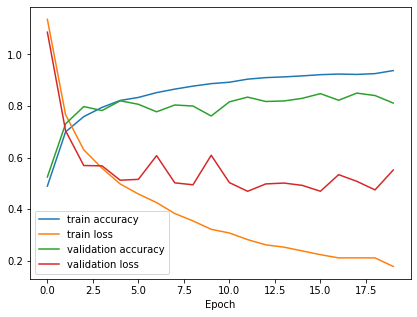

In [77]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')

# plt.subplot(1, 2, 2)

# plt.xlabel('Epoch')
# plt.legend(loc='lower left')

test_loss, test_acc = model.evaluate(test_img,  test_labels, verbose=0)

print(f"acc is {test_acc*100}%")

Lets see balanced accuracy

In [78]:
from sklearn.metrics import balanced_accuracy_score

pred_labels = model.predict(test_img)

pred_labels = np.array([np.argmax(label) for label in pred_labels])

print(f"balanced acc is: {balanced_accuracy_score(test_labels, pred_labels)*100}")

balanced acc is: 79.53245368877423


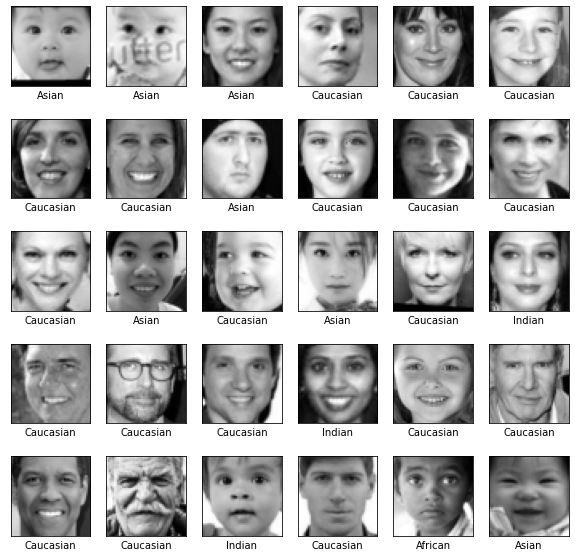

(1290,)
[0 0 2 0 0 3 0 3 0 0 2 2 0 0 3 1 2 0 3 3 0 0 3 2 0 1 3 0 0 2]


In [79]:
predicted_Labels = model.predict(X_TEST)

showImages(X_TEST, predicted_Labels, offset=756) #offset 756 mostra o steve carell e o han solo hahaha

y_pred = np.array([np.argmax(label) for label in predicted_Labels])
print(y_pred.shape)
print(y_pred[10:40])

# with open("predicted_80.0bacc_84.5acc.npy", "wb") as f:
#     np.save(f, y_pred)

(1, 50, 50, 1)
Caucasian


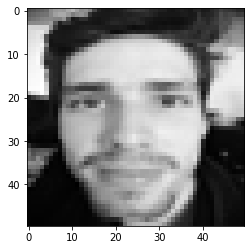

In [82]:
import PIL
an_image = PIL.Image.open("image3.jpg").convert('L').resize((50,50))

image_array = np.asarray(an_image)

image_array = image_array/255
image_array = image_array.reshape(-1,50,50,1)
print(image_array.shape)

predicted = model.predict(image_array)
class_names = ['Caucasian', 'African', 'Asian', 'Indian']
plt.imshow(image_array[0], cmap="gray")
print(class_names[ int( np.argmax(predicted) ) ])